In [ ]:
import tensorflow as tf # For importing tensorflow.

import tensorflow_hub as hub # For importing tensorflow-hub, which contains our pre-trained model.

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the provided image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time. It shows any form of interference that can be derailing to the Object Detection machine's operations, which helps the machine determine the needed adjustments for optimizing its processes and reducing the advent of incurring losses and low productivity rates.
import time

# Print Tensorflow version
print(tf.__version__)

# Checks for available GPU devices. # If GPU devices are not available, do Runtime > Change runtime type > GPU.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.5.0
The following GPU devices are available: /device:GPU:0


In [ ]:
# For displaying the provided image with a height of 20, a width of 15, and without a grid on it
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image) #For showing the image

# For resizing the image with a width of 256px and a height of 256px
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url) # For opening the URL containing the image
  image_data = response.read() # For reading the image conatined within the URL
  image_data = BytesIO(image_data) # For transforming the image into a byte stream
  pil_image = Image.open(image_data) # For opening the iamge 
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # For returning a sized and cropped version of the image, cropped to the requested aspect ratio and size.
  pil_image_rgb = pil_image.convert("RGB") # For converting the pilled image to the RGB format
  pil_image_rgb.save(filename, format="JPEG", quality=90) # For saving the image in JPEG format with a quality of 90. Higher quality number = better image, but not necesseraily better results when it comes to Object Detection
  print("Image downloaded to %s." % filename) # For displaying the name of the downloaded file
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image, 
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

  draw = ImageDraw.Draw(image) # For adding a bounding box to the downloaded image 
  im_width, im_height = image.size # For determining the downloaded image's size using the width and height of the image
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height) # For determining the boundaries of the image using the following parameters: xmin, im_width, xmax, ymin, im_height, and ymax.
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color) # For drawing the boundaries with the values of left, right, top, and bottom and filling the boudaries with color.

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05px.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  # Overlay labeled boxes on an image with formatted scores and label names.
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", # Specifies the font that will be used in the boxes
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmpa4iohvhq.jpg.


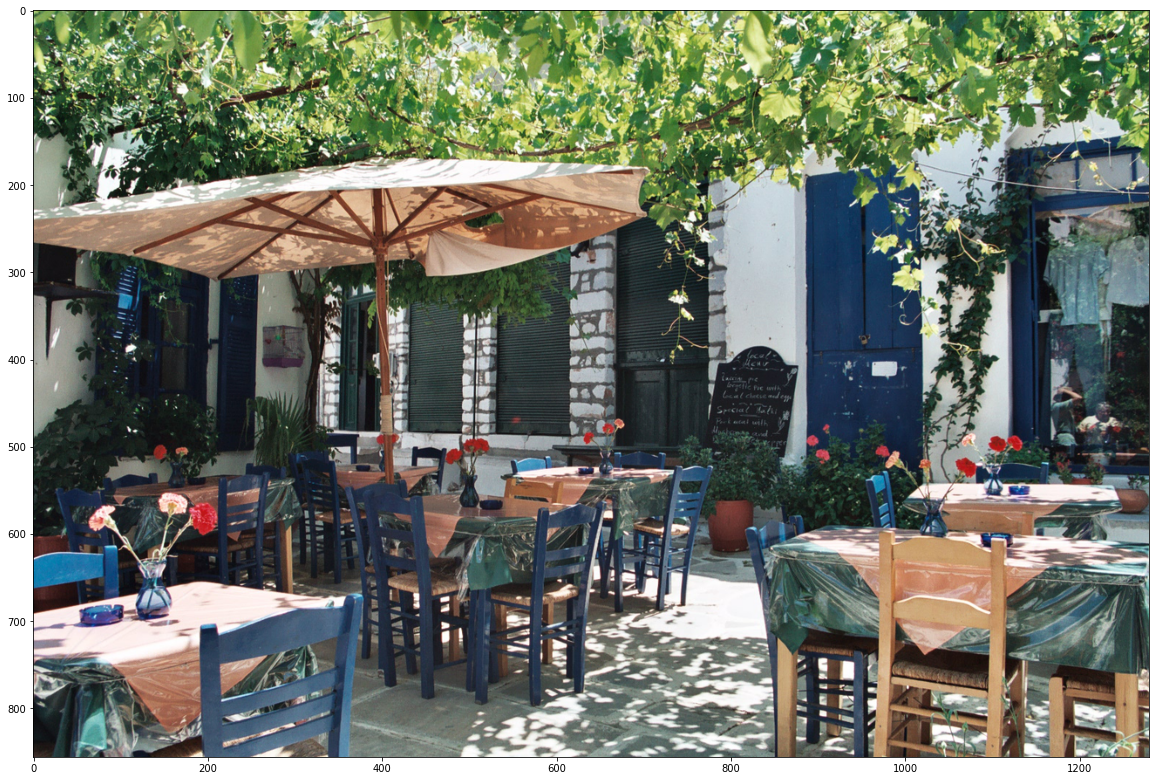

In [ ]:
# For specifiying the image's url that will be used for Object Detection
image_url = "https://gameranx.com/wp-content/uploads/2017/09/27-1400x933.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True) # For downloading the iamge to to /tmp/tmpa4iohvhq.jpg. and resizing the image width to 1280 and image height to 856

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
# For loading the pre-trained model that will be used for Object Detection: faster_rcnn/openimages_v4/inception_resnet_v2
detector = hub.load(module_handle).signatures['default'] # For setting the module handle and signatures to default

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
def load_img(path): # For loading the image with its path parameter
  img = tf.io.read_file(path) # For reading the byte stream path
  img = tf.image.decode_jpeg(img, channels=3) # For decoding the image in jpeg format
  return img

In [ ]:
def run_detector(detector, path): #For detecting the object that are present in the image
  img = load_img(path) # For defining the img varaible using the image's path

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...] # For converting the image into float 32 dtype (describes how the bytes in the fixed-size block of memory corresponding to an array item should be interpreted) whilst adding a newaxis at the beginning of the tensor
  start_time = time.time() # For starting the time. This operation will help the machine in its interference time calculations.
  result = detector(converted_img) # For calling the detector function on converted img. This operation will enable the detector to detect the objects present in the image
  end_time = time.time() # For ending the time. This operation will help the machine in its interference time calculations

  result = {key:value.numpy() for key,value in result.items()} # For storing the detected objects in the result.times

  print("Found %d objects." % len(result["detection_scores"])) # For printing the object's names and their pecentages of certainty
  print("Inference time: ", end_time-start_time) # For printing the interference time

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"]) # For drawign boxes taht surround each detected object

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  59.1169638633728


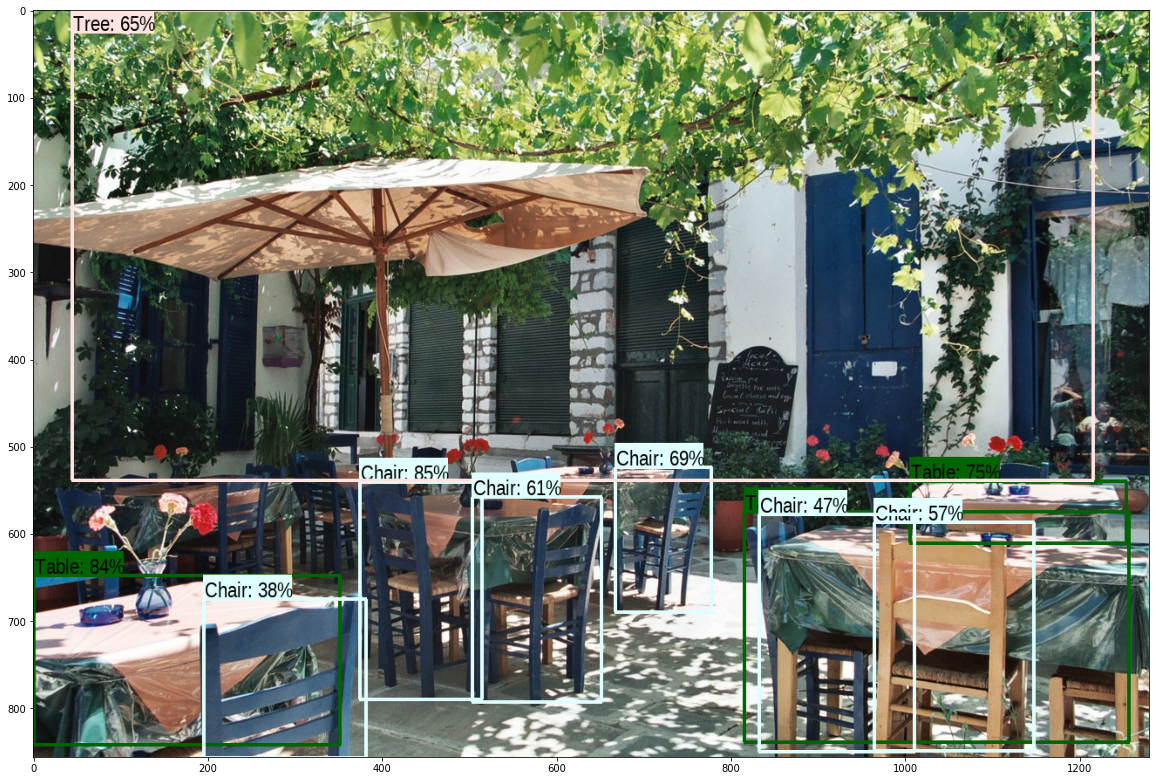

In [ ]:
run_detector(detector, downloaded_image_path) # Runs the detector on the downloaded image path and prints the results

In [ ]:
image_urls = [ # You can replace the urls with your prefered url that contains the image that you want to be processed 
  "https://th.bing.com/th/id/OIP.Q0QKOo1bBE1nbdxliNcuhwHaE8?pid=ImgDet&rs=1",
  "https://th.bing.com/th/id/OIP.ks_bCGX4WiIyc1uoo45cPQHaEo?pid=ImgDet&rs=1",
  "https://www.bing.com/images/search?view=detailV2&ccid=xaBfC2m2&id=C5F1041C4590654A3B81F78A3A89C54FDB8E336B&thid=OIP.xaBfC2m2DclPf0vApBDD9gHaFj&mediaurl=https%3a%2f%2fadorable-home.com%2fwp-content%2fuploads%2f2020%2f01%2fUpdated-backyard.jpg&cdnurl=https%3a%2f%2fth.bing.com%2fth%2fid%2fR.c5a05f0b69b60dc94f7f4bc0a410c3f6%3frik%3dazOO20%252fFiTqK9w%26pid%3dImgRaw&exph=900&expw=1200&q=backyard&simid=608039503766121653&FORM=IRPRST&ck=570B3746C743A1E6BFD9EA6708E0155B&selectedIndex=0&ajaxhist=0&ajaxserp=0",
  ]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

In [ ]:
detect_img(image_urls[0]) # Runs the detector on the first url's image and prints the results

In [ ]:
detect_img(image_urls[1]) # Runs the detector on the second url's image and prints the results

In [ ]:
detect_img(image_urls[2]) # Runs the detector on the third url's image and prints the results